In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import os

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
optima = {
    "br17":     39,
    "ft53":   6905,
    "ft70":  38673,
    "ftv33":  1286,
    "ftv35":  1473,
    "ftv38":  1530,
    "ftv44":  1613,
    "ftv47":  1776,
    "ftv55":  1608,
    "ftv64":  1839,
    "ftv70":  1950,
    "ftv90":  1579,
    "ftv100": 1788,
    "ftv110": 1958,
    "ftv120": 2166,
    "ftv130": 2307,
    "ftv140": 2420,
    "ftv150": 2611,
    "ftv160": 2683,
    "ftv170": 2755,
    "kro124p":36230,
    "p43":    5620,
    "rbg323": 1326,
    "rbg358": 1163,
    "rbg403": 2465, 
    "rbg443": 2720,
    "ry48p": 14422,
}

In [4]:
def annotate_ordering(df: pd.DataFrame) -> pd.DataFrame:
    df["instance_size"] = df.instance.apply(lambda x: int(re.search(r'\d+', x).group()))
    df["method_idx"] = df["method"].apply(lambda x: all_methods.index(x))
    return df.sort_values(by=['instance_size', 'method_idx'])

sa_res_df = pd.read_json('../data/results/sa-out-10.json')
ts_res_df = pd.read_json('../data/results/ts-out-10.json')
all_res_df = pd.concat([sa_res_df, ts_res_df], ignore_index=True)

selected_instances = all_res_df['instance'].unique()

custom_names = {
    "simulated-annealing": "SA-R",
    "simulated-annealing-nn": "SA-H",
    "tabu-search": "TS-R",
    "tabu-search-nn": "TS-H",
}

all_methods = list(custom_names.values())
all_res_df['method'] = all_res_df['method'].apply(lambda x: custom_names[x])
all_res_df = annotate_ordering(all_res_df).reset_index(drop=True)
all_res_df.shape

(15360, 15)

In [5]:
SA_METHODS = ["SA-R", "SA-H"]
TS_METHODS = ["TS-R", "TS-H"]

COLORS = {
    "SA-R": "#ffff66",
    "SA-H": "#cccc00",
    "TS-R": "#ff3399",
    "TS-H": "#660033"
}

all_res_df["distance"] = all_res_df.apply(lambda row: (row['cost'] - optima[row['instance']]) / optima[row['instance']], axis=1)
groupped_df = all_res_df.groupby(['instance', 'method'])[["distance", "time", "iterations", "steps", "evaluations", 'cost']].agg(['mean', 'std', 'min', 'max'])
groupped_df.columns = ["_".join(x) for x in groupped_df.columns]
stats_df = groupped_df.reset_index()
stats_df = annotate_ordering(stats_df).reset_index(drop=True)
stats_df.head()

,instance,method,distance_mean,distance_std,distance_min,distance_max,time_mean,time_std,time_min,time_max,...,evaluations_mean,evaluations_std,evaluations_min,evaluations_max,cost_mean,cost_std,cost_min,cost_max,instance_size,method_idx
0,ftv33,SA-R,0.717976,0.308910,0.163297,1.427683,1.811755e+05,1.975377e+05,15100,1222540,...,1205.275000,1313.931581,102,8071,2209.316667,397.258097,1496,3122,33,0
1,ftv33,SA-H,0.275732,0.050431,0.171851,0.382582,1.132291e+05,1.657122e+05,5340,1110070,...,721.658333,1047.387632,30,6186,1640.591667,64.854357,1507,1778,33,1
2,ftv33,TS-R,0.442906,0.197798,0.115086,1.247278,3.150468e+06,2.258662e+06,287270,13187350,...,6307.916667,4766.442199,605,33507,1855.577083,254.368468,1434,2890,33,2
3,ftv33,TS-H,0.257429,0.055165,0.127527,0.382582,1.182359e+06,1.387412e+06,56230,9941900,...,2322.393750,2825.670216,110,21462,1617.054167,70.942780,1450,1778,33,3
4,p43,SA-R,0.190884,0.380406,-0.000712,0.986299,1.612938e+07,3.500051e+07,51550,205938700,...,89595.683333,190005.187803,428,1105049,6692.766667,2137.879244,5616,11163,43,0


In [6]:
def plot_violin_by_attr(
        res_df: pd.DataFrame, 
        selected_methods: list[str],
        selected_instances: list[str], 
        attribute: str,
        ax: plt.Axes,
        y_max: int = None,
    ):
    filtered_df = res_df[res_df['method'].isin(selected_methods) & res_df['instance'].isin(selected_instances)]
    sns.violinplot(
        x='instance', 
        y=attribute, 
        hue='method', 
        data=filtered_df, 
        ax=ax,
        linewidth=0, 
        scale='width', 
        palette=COLORS, 
    )
    ax.vlines(
        np.arange(-1, len(selected_instances)) + 0.5, 
        0, 
        filtered_df[attribute].max() if y_max is None else y_max, 
        linestyles='dotted', 
        colors='gray', 
        alpha=0.5,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax


def plot_bars(
    res_df: pd.DataFrame,
    selected_methods: list[str],
    selected_instances: list[str],
    attribute: str,
    ax: plt.Axes,
    err_attribute: str = None,
    x_attr: str = 'instance',
):
    filtered_df = res_df[res_df['method'].isin(selected_methods) & res_df['instance'].isin(selected_instances)]
    sns.barplot(
        x=x_attr, 
        y=attribute, 
        hue='method',
        data=filtered_df, 
        ax=ax,
        palette=COLORS,
    )
    if err_attribute:
        x_coords = np.array([p.get_x() + p.get_width() / 2 for p in ax.patches])
        y_coords = np.array([p.get_height() for p in ax.patches])
        sorted_idx = np.argsort(x_coords)
        x_coords = x_coords[sorted_idx][:filtered_df.shape[0]]
        y_coords = y_coords[sorted_idx][:filtered_df.shape[0]]
        y_err = filtered_df[err_attribute].to_numpy()
        ax.errorbar(x_coords, y_coords, yerr=y_err, fmt='none', ecolor='black', capsize=2)


    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

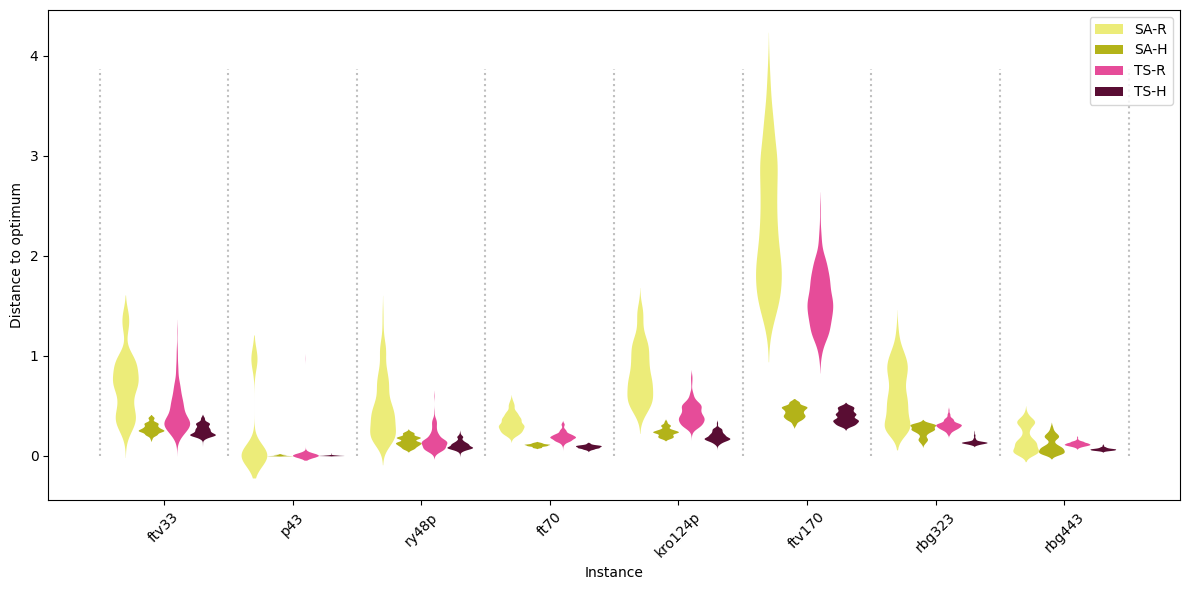

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True)
plot_violin_by_attr(all_res_df, [*TS_METHODS, *SA_METHODS], selected_instances, "distance", ax)
ax.set_ylabel("Distance to optimum")
ax.set_xlabel("Instance")
ax.legend()

plt.tight_layout()
plt.savefig("plots/1/violin_distance.png")
plt.show()

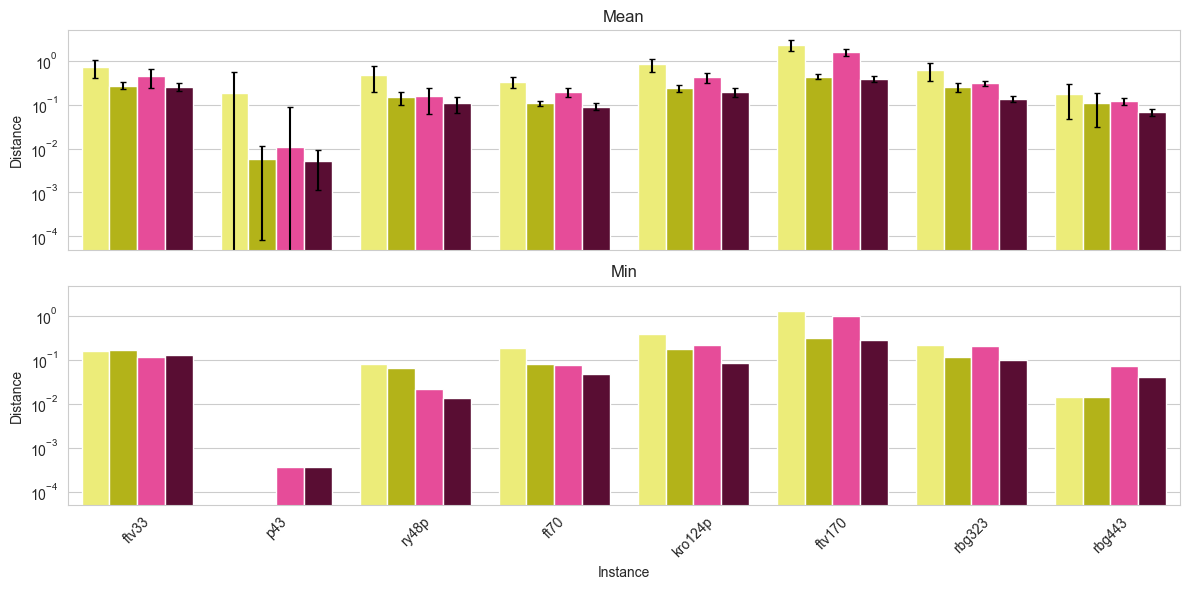

In [8]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharey=True, sharex=True)
    plot_bars(stats_df, [*TS_METHODS, *SA_METHODS], selected_instances, "distance_mean", axs[0], "distance_std")
    axs[0].set_ylabel("Distance")
    axs[0].set_xlabel("")
    axs[0].set_title("Mean")
    axs[0].legend().remove()
    plot_bars(stats_df, [*TS_METHODS, *SA_METHODS], selected_instances, "distance_min", axs[1])
    axs[1].legend().remove()
    axs[1].set_ylabel("Distance")
    axs[1].set_xlabel("Instance")
    axs[1].set_title("Min")
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

#Consider reducing space by shorter abbreviation

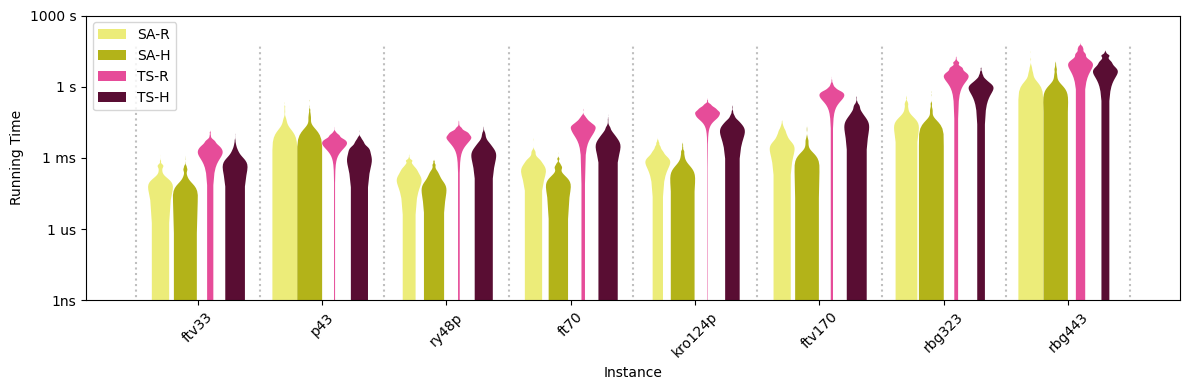

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plot_violin_by_attr(all_res_df, [*SA_METHODS, *TS_METHODS], selected_instances, "time", ax)

ax.legend()
ax.set_ylabel("Running Time")
ax.set_xlabel("Instance")
plt.yscale('log')
plt.yticks([10**i for i in range(0, 13, 3)], ["1ns", "1 us", "1 ms", "1 s", "1000 s"])
plt.tight_layout()
plt.savefig("plots/1/violin_time.png")
plt.show()

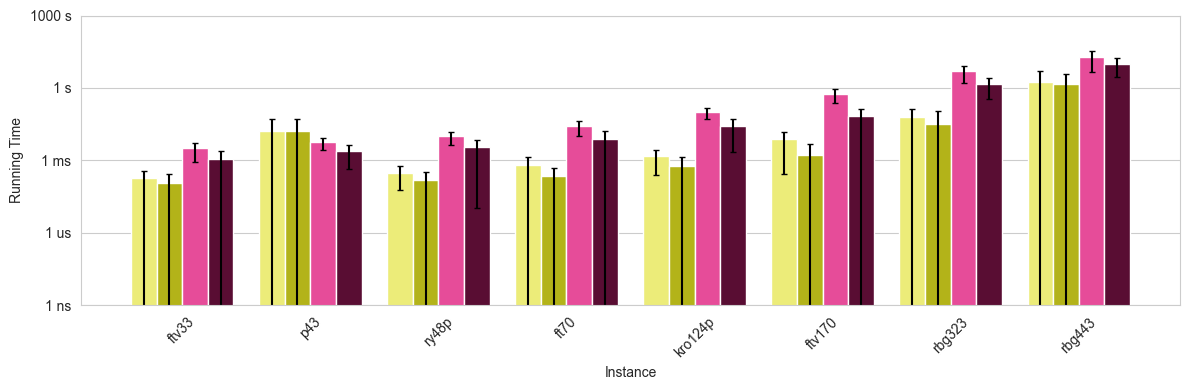

In [10]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plot_bars(stats_df, TS_METHODS + SA_METHODS, selected_instances, "time_mean", ax, "time_std")
    ax.set_ylabel("Running Time")
    ax.set_xlabel("Instance")
    ax.get_legend().remove()
    
    plt.yscale('log')
    plt.yticks([10**i for i in range(0, 13, 3)], ["1 ns", "1 us", "1 ms", "1 s", "1000 s"])
    plt.tight_layout()
    plt.savefig("plots/1/bar_time.png")
    plt.show()

# SA - per param spec analysis

In [50]:
rename_dict = {
    "meta-param-1": "temperature",
    "meta-param-2": "cooling_rate",
    "meta-param-3": "markov_chain_length"
}
sa_res_df = all_res_df[all_res_df['method'].isin(SA_METHODS)].rename(columns=rename_dict)
sa_groupped_df = sa_res_df.groupby(['instance', 'method', "temperature", "cooling_rate", "markov_chain_length"])[["distance", "time", "iterations", "steps", "evaluations", 'cost']].agg(['mean', 'std', 'min', 'max'])
sa_groupped_df.columns = ["_".join(x) for x in sa_groupped_df.columns]
sa_stats_df = sa_groupped_df.reset_index()
sa_stats_df = annotate_ordering(sa_stats_df).reset_index(drop=True)

In [52]:
for col in rename_dict.values():
    sa_stats_df[col] = sa_stats_df[col].apply(lambda x: f"{x:.2f}")

In [59]:
tempratures = sa_stats_df["temperature"].unique()
cooling_rates = sa_stats_df["cooling_rate"].unique()
chain_lengths = sa_stats_df["markov_chain_length"].unique()

best_params = sa_stats_df.groupby(['instance', "method"])['distance_mean'].idxmin()
best_params_df = sa_stats_df.loc[best_params]
mode_agg = lambda x: pd.Series.mode(x)[0]
best_temp = best_params_df.groupby(['instance'])['temperature'].agg(mode_agg)
best_cooling_rate = best_params_df.groupby(['instance'])['cooling_rate'].agg(mode_agg)
best_chain_length = best_params_df.groupby(['instance'])['markov_chain_length'].agg(mode_agg)

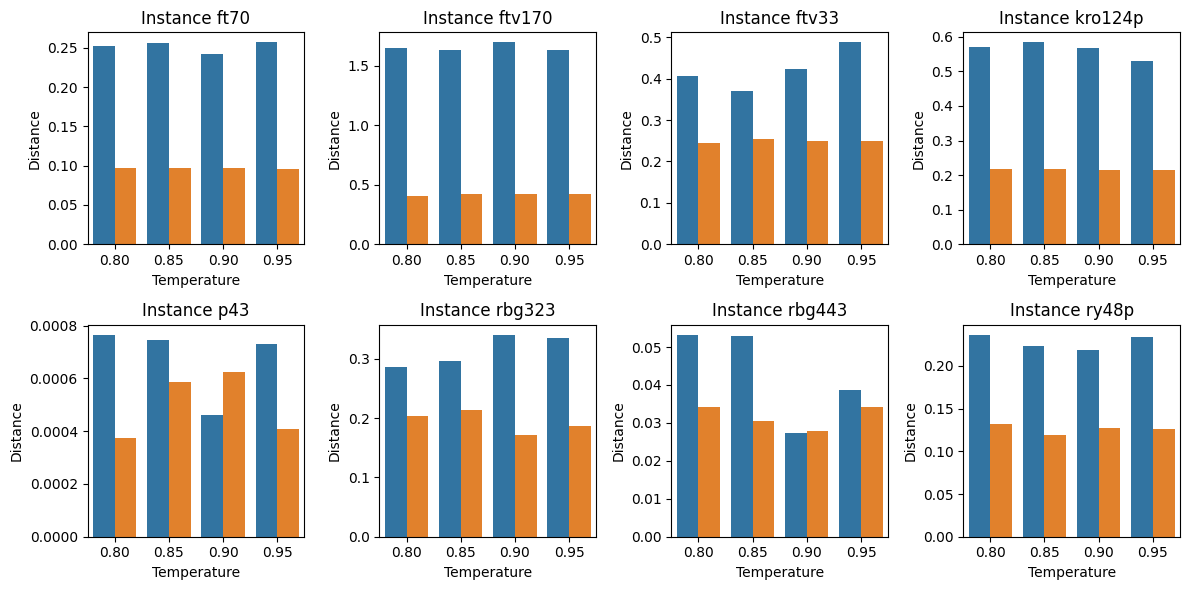

In [60]:
fig, axs = plt.subplots(len(selected_instances) // 4, len(selected_instances) // 2, figsize=(12, 6))
for i, (instance, ax) in enumerate(zip(selected_instances, axs.flatten())):
    instance_df = sa_stats_df[(sa_stats_df['instance'] == instance) & (sa_stats_df["cooling_rate"] == best_cooling_rate[instance]) &  (sa_stats_df["markov_chain_length"] == best_chain_length[instance])]
    ax.set_title(f"Instance {instance}")
    sns.barplot(x="temperature", y="distance_mean", hue="method", data=instance_df, ax=ax)
    ax.set_ylabel("Distance")
    ax.set_xlabel("Temperature")
    ax.get_legend().remove()

plt.tight_layout()

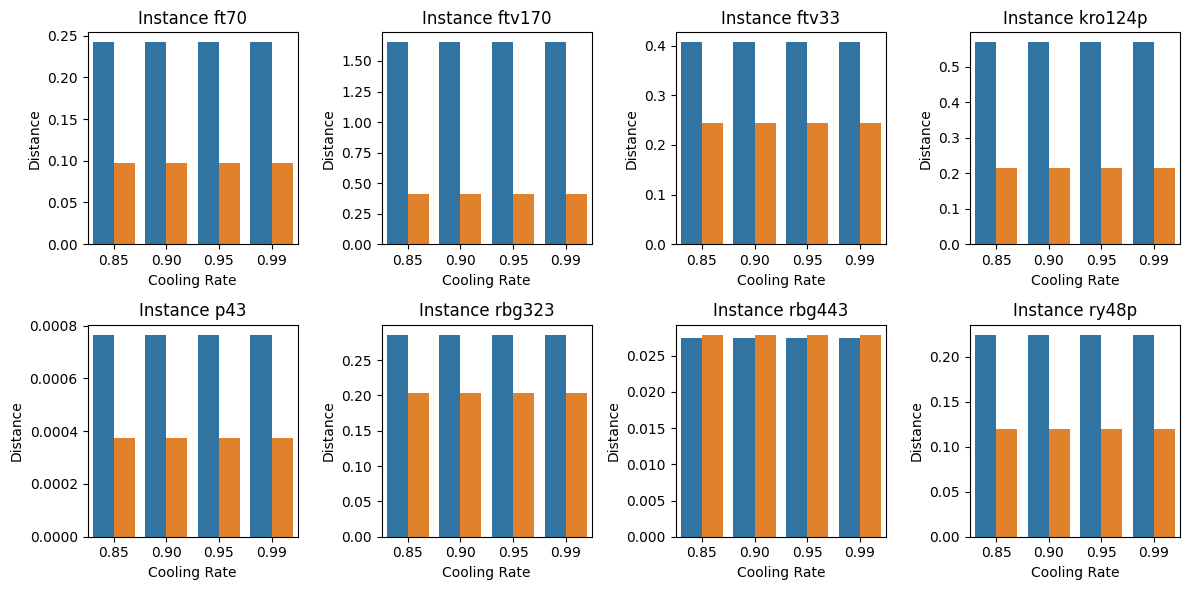

In [61]:
fig, axs = plt.subplots(len(selected_instances) // 4, len(selected_instances) // 2, figsize=(12, 6))
for i, (instance, ax) in enumerate(zip(selected_instances, axs.flatten())):
    instance_df = sa_stats_df[(sa_stats_df['instance'] == instance) & (sa_stats_df["temperature"] == best_temp[instance]) &  (sa_stats_df["markov_chain_length"] == best_chain_length[instance])]
    ax.set_title(f"Instance {instance}")
    sns.barplot(x="cooling_rate", y="distance_mean", hue="method", data=instance_df, ax=ax)
    ax.set_ylabel("Distance")
    ax.set_xlabel("Cooling Rate")
    ax.get_legend().remove()

plt.tight_layout()

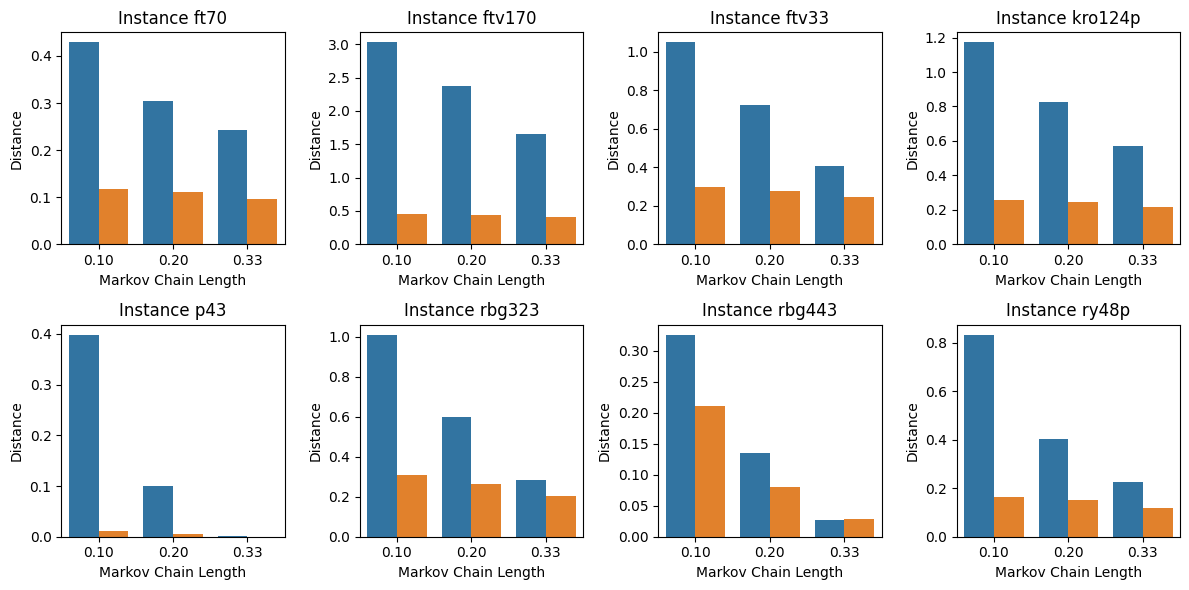

In [62]:
fig, axs = plt.subplots(len(selected_instances) // 4, len(selected_instances) // 2, figsize=(12, 6))
for i, (instance, ax) in enumerate(zip(selected_instances, axs.flatten())):
    instance_df = sa_stats_df[(sa_stats_df['instance'] == instance) & (sa_stats_df["temperature"] == best_temp[instance]) &  (sa_stats_df["cooling_rate"] == best_cooling_rate[instance])]
    ax.set_title(f"Instance {instance}")
    sns.barplot(x="markov_chain_length", y="distance_mean", hue="method", data=instance_df, ax=ax)
    ax.set_ylabel("Distance")
    ax.set_xlabel("Markov Chain Length")
    ax.get_legend().remove()

plt.tight_layout()